# COGS 118A - Final Project

IMDB Movie Gross Income Predictor

# Names

- Carly Freedman
- Jackson Teel
- Ye Yint Win
- Garrett Dungca

# Abstract 
We would like to create a program to predict the gross income in U.S. dollars of movies based on their year, certificate, runtime, genre, rating and total number of votes. The certificate gives the movie rating (i.e. PG-13), the rating represents the total score received by the movies from reviewers on IMDB, and the total number of votes is how many people reviewed the movie total. We will be using a dataset containing all of these variables for every movie on IMDB. We are going to one-hot encode each of the categories. In order to predict the gross income we will be using and comparing several regression models such as decision tree regression, LASSO, Ridge, and linear regression. We will use a loss value based on the actual gross income vs. predicted gross income.

# Background

There have been many studies conducted on predicting gross income of movies. However, there are few accurate ones. Most studies produce an accuracy in the 50-60% range. For example, a study conducted on this topic using both standard linear regression and classification via logistic regression only produced an accuracy of about 75% <a name="yoo"></a>[<sup>[1]</sup>](#yoonote). Given that this study was likely limited by the types of analysis they performed, we would like to determine if there is any way to increase this accuracy using a wider variety of algorithms and a different dataset. In our own analysis, we will likely use standard linear regression as well, but as a baseline reference for our other algorithms.

Using machine learning algorithms to predict gross income of movies has several benefits. Accurate income predictions can help movie studios, producers, and investors make better business decisions. It allows for more informed decisions to be made with regard to budgeting, marketing, and distribution<a name="dhir"></a>[<sup>[2]</sup>](#dhirnote). These predictions can also help filmmakers and studios create movies that are more engaging to their audience. ML algorithms can be used to analyze audience preferences based on demographics and other key variables that help inform creative decisions. From the article titled, ‘Popularity prediction of movies: from statistical modeling to machine learning techniques’, we were inspired to use a Decision Tree model for our predictions as it turned out to be one of the more accurate models in their case. <a name="abidi"></a>[<sup>[3]</sup>](#abidinote).

# Problem Statement

Our problem is to predict the gross box office earnings of a movie based on features such as genre, rating, runtime, certificate, year, and votes. Logically, we would think that in some way metrics such as these which would describe the popularity of a movie would be a good indicator of how much revenue that movie will bring in. 
We are aiming to get a predicted value as close to the actual value as possible. We will be one-hot-encoding the only non-numerical value, genre, so we should be able to get good, interpretable results through metrics such as mean-squared-error (MSE), root-mean-squared-error (RMSE), mean average error (MAE), and R^2 Value. 

Given that our model provides reliable information when predicting gross box office earnings, the hope is for our model to help movie studios, producers, and investors to make more informed business decisions about budgeting, marketing, and distribution of their movies. Alternatively, our analysis may reveal that the features we used are not informative enough, even given a variety of complex models and approaches, in which we would determine that the data obtained from IMDb should not be used alone in future research and may need to include more complex features or deeper additional analysis such as sentiment analysis of reviews. Additionally, if we determine that our models’ accuracy stagnate even as we add more complexity (accounting for methods to prevent overfitting), we may conclude that the features we did use poorly map onto box office earnings, suggesting that IMDb data is wholly uninformative when determining the financial success of a movie. 

# Data
Link to dataset: <a>https://www.kaggle.com/datasets/rajugc/imdb-movies-dataset-based-on-genre?resource=download</a>

Column Descriptions:

 • movie_id - IMDB Movie ID

 • movie_name - Name of the movie

 • year - Release year

 • certificate - Certificate of the movie

 • run_time - Total movie run time

 • genre - Genre of the movie

 • rating - Rating of the movie

 • description - Description of the movie

 • director - Director of the movie

 • director_id - IMDB id of the director

 • star - Star of the movie

 • star_id - IMDB id of the star

 • votes - Number of votes in IMDB website
 
 • gross(in $) - Gross Box Office of the movie


The dataset starts with 298975 total observations, and 14 variables. Once we remove the observations with Null values, we have 18709 total observations. Additionally, we are only interested in 6 of the variables as aforementioned because several of the variables are string values that would be too lengthy to one-hot encode. A valid observation must include the features: year (integer), certificate, runtime (float), genre, rating (float), votes (integer), and gross income (float), and it must also have no null values. These variables are a combination of ordinal variables and categorical variables which are able to be one-hot encoded. Therefore they will be usable by our program.
Many of the movies in the dataset are listed under several genres. In total there are 40 unique genres listed in the dataset, but the data is organized into 13 folders: one for each main genre of movie. To save some computational expense in feature selection, we are going to only use the genre that corresponds to the directory that the movie was initially listed under. 
Additionally, in our data cleaning portion, we omit movies that are older than 1997. This is because the movie industry has undergone major changes the past couple decades and we want our machine learning model to be trained on data representative of the current movie market. 
The variables that we one-hot encode are genre and certificate. There are 27 unique certificates to start off with, but shorten this down to 6 since a handful of the certificates are old certificates that no longer exist or are show certificates. We also one-hot encode 12 unique genres in our dataset. These genres include (action, adventure, crime, family, fantasy, history, horror, mystery, scifi, sports, thriller, and war). Since we are not looking movies older than 1997, we decided to one-hot-encode the years in 5 year increments starting from 1995 to 2024 (e.g. 1995-2004, 2005-2009, …, 2019-2024) so that we can train them as an additional categorical feature.
Last part of our data cleaning process is getting rid of outliers. We already eliminate a significant portion of outliers with regards to year when we only take the past 25 years into consideration but we also eliminate some of the outliers when it comes to runtime. Movies longer than 300 minutes will be omitted as our data contains two very extreme outliers (well over 1.5 times IQR) with regards to runtime that could potentially negatively impact the accuracy of our model.
We check for multicollinearity using a correlation matrix. We will eliminate values with correlation coefficients greater than 0.7.

# Data Cleaning
## Imports

In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.svm import SVR
# from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import os

## Read In Data

In [3]:
path = 'data'

files = glob.glob(path + "/*.csv")
data_frames = []

for file in files:
    frame = pd.read_csv(file)
    frame['genre'] = frame['genre'].apply(lambda x: str(file))
    data_frames.append(frame)

    
df = pd.concat(data_frames, ignore_index=True)
df.head()

,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in $)
0,tt9114286,Black Panther: Wakanda Forever,2022,PG-13,161 min,data\action.csv,6.9,The people of Wakanda fight to protect their h...,Ryan Coogler,/name/nm3363032/,"Letitia Wright, \nLupita Nyong'o, \nDanai Guri...","/name/nm4004793/,/name/nm2143282/,/name/nm1775...",204835.0,NaN
1,tt1630029,Avatar: The Way of Water,2022,PG-13,192 min,data\action.csv,7.8,Jake Sully lives with his newfound family form...,James Cameron,/name/nm0000116/,"Sam Worthington, \nZoe Saldana, \nSigourney We...","/name/nm0941777/,/name/nm0757855/,/name/nm0000...",295119.0,NaN
2,tt5884796,Plane,2023,R,107 min,data\action.csv,6.5,A pilot finds himself caught in a war zone aft...,Jean-François Richet,/name/nm0724938/,"Gerard Butler, \nMike Colter, \nTony Goldwyn, ...","/name/nm0124930/,/name/nm1591496/,/name/nm0001...",26220.0,NaN
3,tt6710474,Everything Everywhere All at Once,2022,R,139 min,data\action.csv,8.0,A middle-aged Chinese immigrant is swept up in...,"Dan Kwan, \nDaniel Scheinert",/name/nm3453283/,"Michelle Yeoh, \nStephanie Hsu, \nJamie Lee Cu...","/name/nm3215397/,/name/nm0000706/,/name/nm3513...",327858.0,NaN
4,tt5433140,Fast X,2023,NaN,NaN,data\action.csv,NaN,Dom Toretto and his family are targeted by the...,Louis Leterrier,/name/nm0504642/,"Vin Diesel, \nJordana Brewster, \nTyrese Gibso...","/name/nm0004874/,/name/nm0108287/,/name/nm0879...",NaN,NaN


## Remove NULL Values

In [4]:
df = df.dropna().reset_index(drop=True)
df.head()


,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in $)
0,tt1825683,Black Panther,2018,PG-13,134 min,data\action.csv,7.3,"T'Challa, heir to the hidden but advanced king...",Ryan Coogler,/name/nm3363032/,"Chadwick Boseman, \nMichael B. Jordan, \nLupit...","/name/nm1569276/,/name/nm0430107/,/name/nm2143...",785813.0,700059566.0
1,tt0092099,Top Gun,1986,PG,109 min,data\action.csv,6.9,As students at the United States Navy's elite ...,Tony Scott,/name/nm0001716/,"Tom Cruise, \nTim Robbins, \nKelly McGillis, \...","/name/nm0000129/,/name/nm0000209/,/name/nm0000...",461419.0,179800601.0
2,tt0499549,Avatar,2009,PG-13,162 min,data\action.csv,7.9,A paraplegic Marine dispatched to the moon Pan...,James Cameron,/name/nm0000116/,"Sam Worthington, \nZoe Saldana, \nSigourney We...","/name/nm0941777/,/name/nm0757855/,/name/nm0000...",1322694.0,760507625.0
3,tt1392170,The Hunger Games,2012,PG-13,142 min,data\action.csv,7.2,Katniss Everdeen voluntarily takes her younger...,Gary Ross,/name/nm0002657/,"Jennifer Lawrence, \nJosh Hutcherson, \nLiam H...","/name/nm2225369/,/name/nm1242688/,/name/nm2955...",927499.0,408010692.0
4,tt1160419,Dune,2021,PG-13,155 min,data\action.csv,8.0,A noble family becomes embroiled in a war for ...,Denis Villeneuve,/name/nm0898288/,"Timothée Chalamet, \nRebecca Ferguson, \nZenda...","/name/nm3154303/,/name/nm0272581/,/name/nm3918...",649342.0,108327830.0


## Narrow Down Columns

In [5]:
df = df.loc[:, ['movie_name', 'year', 'certificate', 'runtime', 'genre', 'rating', 'votes', 'gross(in $)']]

df.head()


,movie_name,year,certificate,runtime,genre,rating,votes,gross(in $)
0,Black Panther,2018,PG-13,134 min,data\action.csv,7.3,785813.0,700059566.0
1,Top Gun,1986,PG,109 min,data\action.csv,6.9,461419.0,179800601.0
2,Avatar,2009,PG-13,162 min,data\action.csv,7.9,1322694.0,760507625.0
3,The Hunger Games,2012,PG-13,142 min,data\action.csv,7.2,927499.0,408010692.0
4,Dune,2021,PG-13,155 min,data\action.csv,8.0,649342.0,108327830.0


## Format Columns

In [6]:
#Format runtimes into floats
def convert_runtime(string):
    return float(string.split(' ')[0])
    
df['runtime'] = df['runtime'].apply(convert_runtime)
df = df[df['runtime'] < 300]


#Format genre by using only first value
def genre_parse(genre):
   
    genre = genre.split('\\')[-1] # remove directory path
    genre = genre[:-4]
    
    genre = genre.lower()
    
    return genre
  
df['genre']=df['genre'].apply(genre_parse)
df = df.drop(df.loc[(df['genre'] == 'musical') | (df['genre'] == 'romance') | (df['genre'] == 'biography') | (df['genre']=='animation')].index)

# Format Certificate filter out all data points to only include movies with the G, PG, PG-13, R, and NC-17 ratings, switch Not Rated to NR
def convert_unrated(certificate):
    if certificate == 'Not Rated':
        return 'NR'
    else:
        return certificate
    
df=df.loc[(df['certificate'] == 'R') | (df['certificate'] =='PG-13') | (df['certificate'] == 'PG') | (df['certificate'] == 'Not Rated') | (df['certificate'] =='X') | (df['certificate'] == 'NC-17')]
df['certificate']=df['certificate'].apply(convert_unrated)

#Format years into ints and include only the past 25 years worth of data. 
df['year'] = df['year'].astype(int)
df = df.loc[(df['year'] >= 1997)].reset_index(drop=True)

df.head()

,movie_name,year,certificate,runtime,genre,rating,votes,gross(in $)
0,Black Panther,2018,PG-13,134.0,action,7.3,785813.0,700059566.0
1,Avatar,2009,PG-13,162.0,action,7.9,1322694.0,760507625.0
2,The Hunger Games,2012,PG-13,142.0,action,7.2,927499.0,408010692.0
3,Dune,2021,PG-13,155.0,action,8.0,649342.0,108327830.0
4,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,178.0,action,8.8,1889727.0,315544750.0


# Data Engineering

## Remove Repeats and One Hot Encode

In [7]:
df_pre_eng = df
genres = df['genre'].unique()
for genre in genres:
    df[genre] = 0
names = df['movie_name'].unique()

for name in names:
    repeats = df.loc[(df['movie_name'] == name)]
    genres = []
    
    for index in list(repeats.index):
        genres.append(repeats.loc[index,'genre'])
    
    for genre in genres:
        df.loc[list(repeats.index)[0], genre] = 1
    
    df = df.drop(list(repeats.index)[1:])
    
df=df.drop(['movie_name', 'genre'], axis=1)
df.head()

,year,certificate,runtime,rating,votes,gross(in $),action,adventure,crime,family,fantasy,history,horror,mystery,scifi,sports,thriller,war
0,2018,PG-13,134.0,7.3,785813.0,700059566.0,1,1,0,0,0,0,0,0,1,0,0,0
1,2009,PG-13,162.0,7.9,1322694.0,760507625.0,1,1,0,0,1,0,0,0,1,0,0,0
2,2012,PG-13,142.0,7.2,927499.0,408010692.0,1,1,0,0,0,0,0,0,1,0,1,0
3,2021,PG-13,155.0,8.0,649342.0,108327830.0,1,1,0,0,0,0,0,0,1,0,0,0
4,2001,PG-13,178.0,8.8,1889727.0,315544750.0,1,1,0,0,1,0,0,0,0,0,0,0


## Scale down gross earnings from dollars to millions of dollars

In [8]:
df['gross(in $)'] = df['gross(in $)']/1e6

# EDA

<Figure size 4000x4000 with 0 Axes>

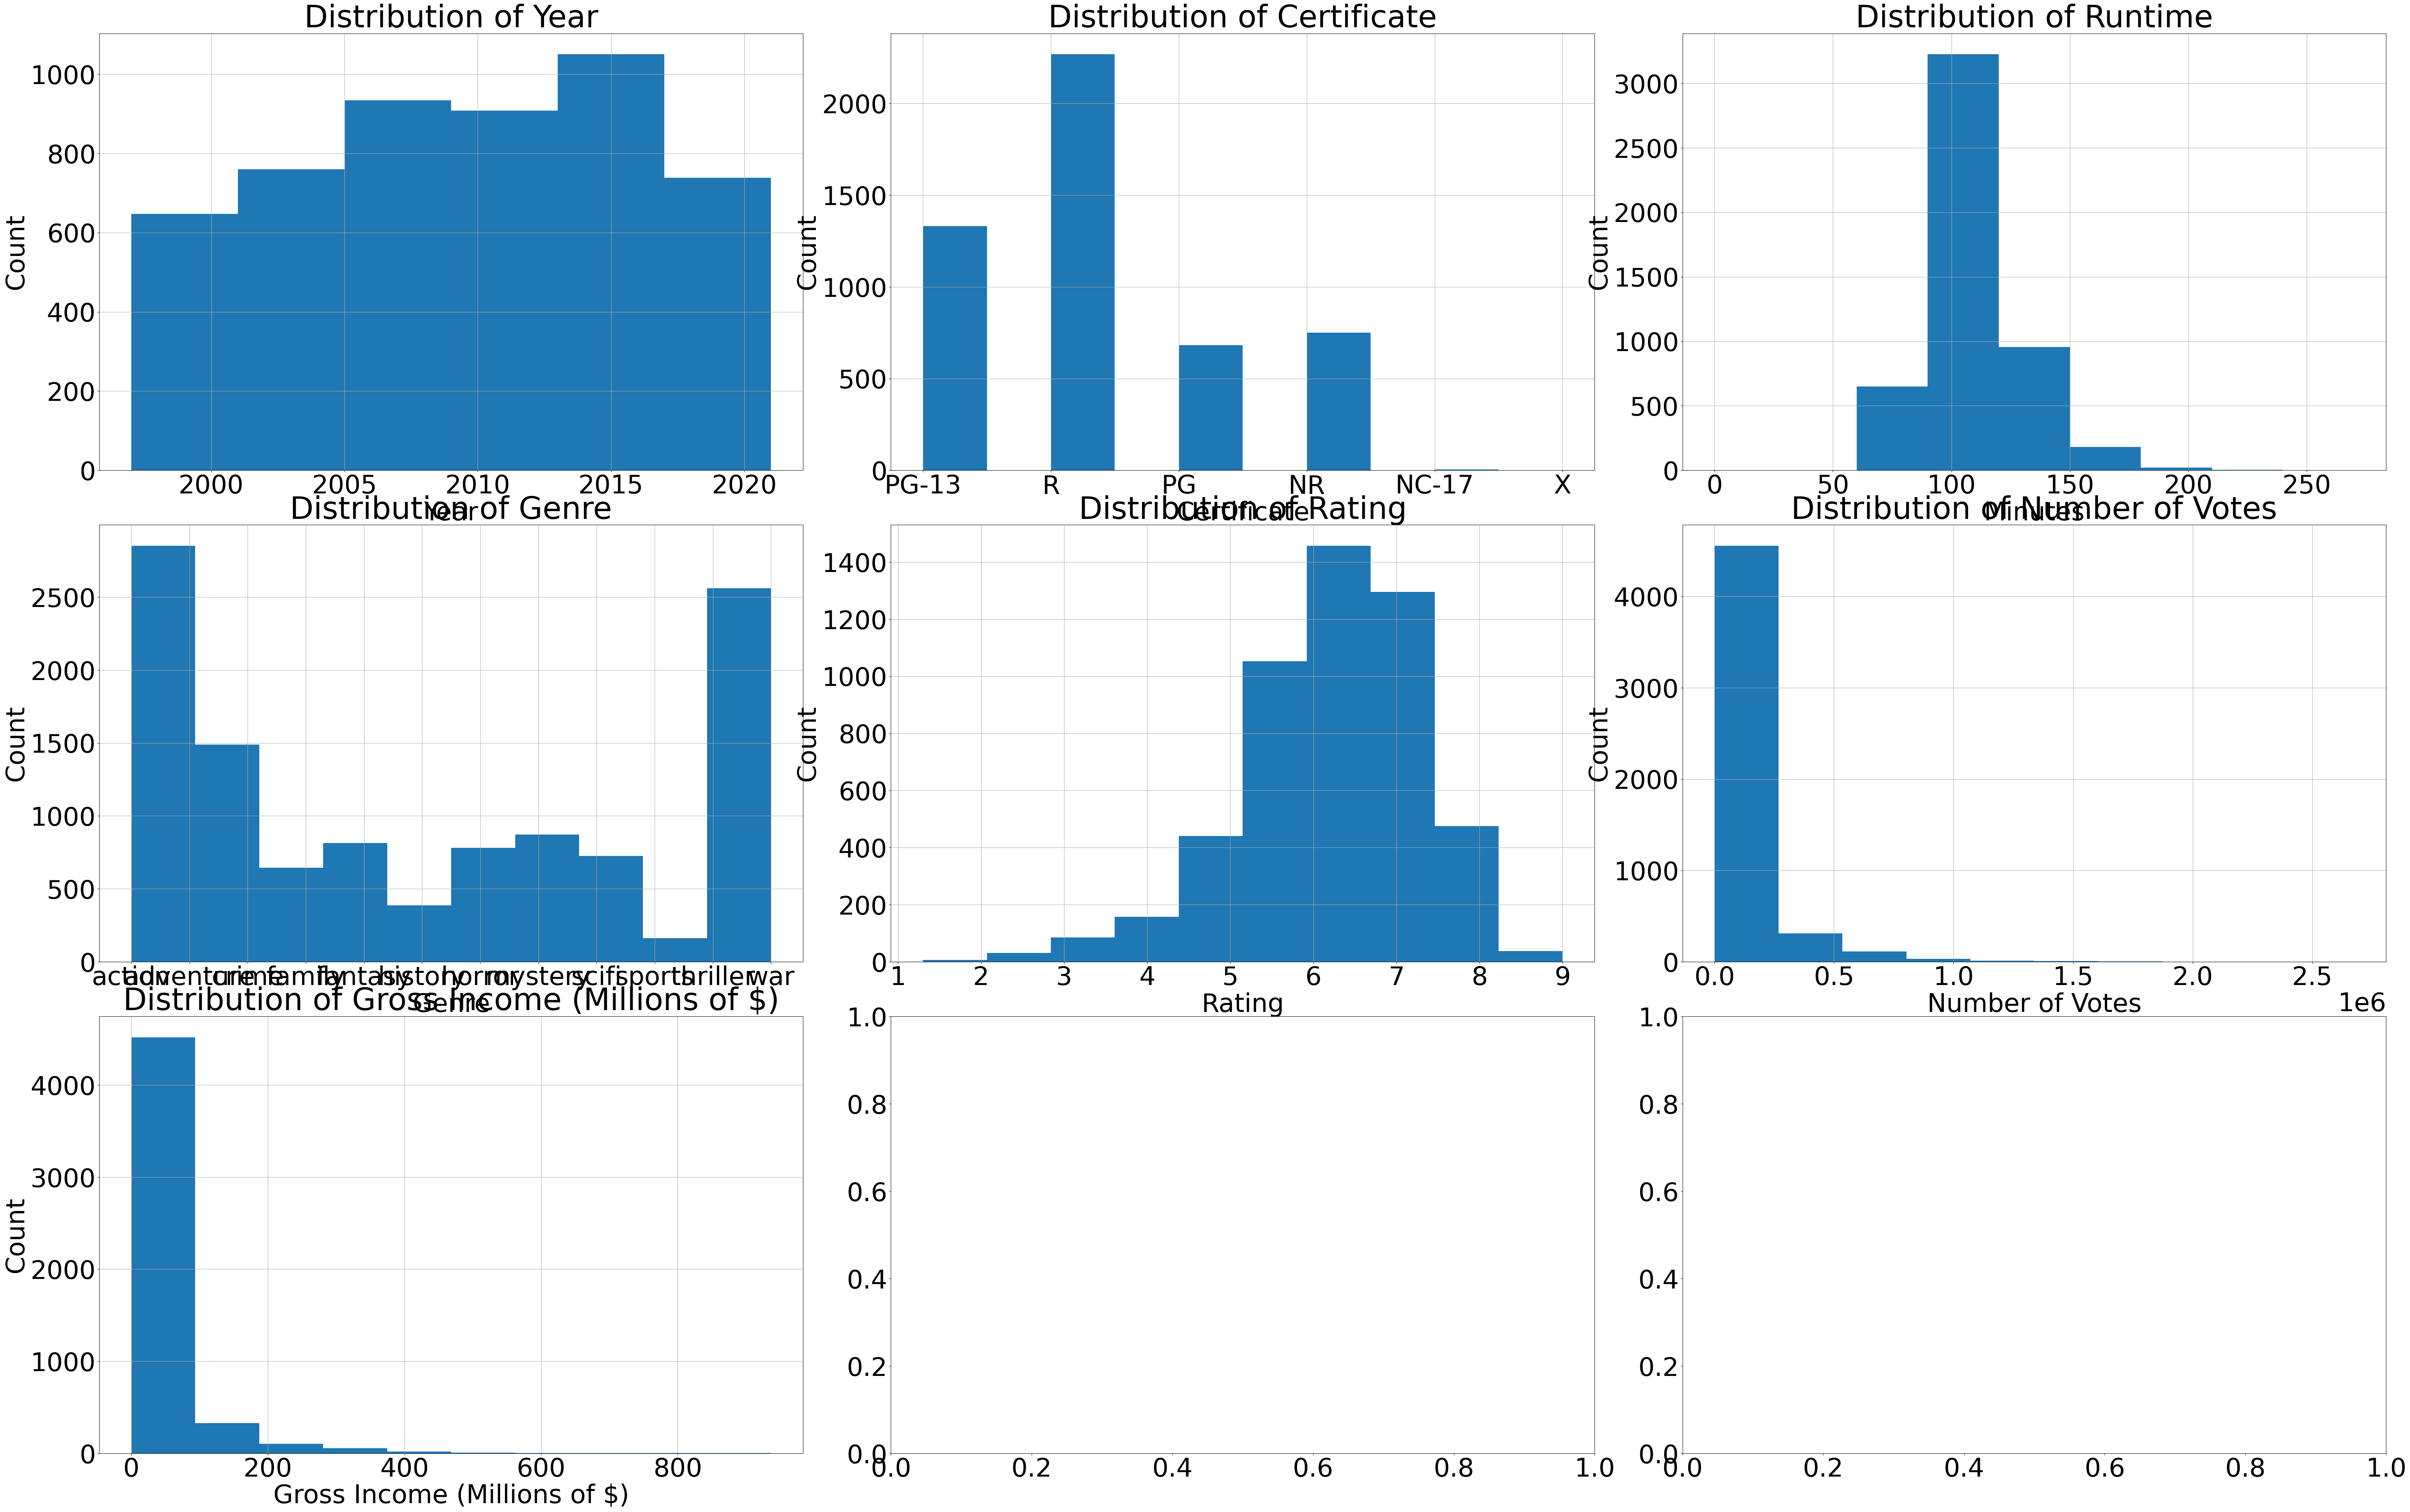

Earliest Year: 1997
Latest Year: 2022
['action' 'adventure' 'crime' 'family' 'fantasy' 'history' 'horror'
 'mystery' 'scifi' 'sports' 'thriller' 'war']
Shortest Movie Runtime: 45.0 min
Longest Movie Runtime: 219.0 min
Average Movie Runtime: 108.20007939658595 min


In [9]:
from matplotlib.gridspec import GridSpec
plt.figure(figsize=(40,40))
plt.rc('font', size=50)          # controls default text sizes    # fontsize of the x and y labels
plt.rc('xtick', labelsize=50)    # fontsize of the tick labels
plt.rc('ytick', labelsize=50) 
fig, (ax1, ax2, ax3) = plt.subplots(3, 3, gridspec_kw={'wspace':1/8, 'hspace':1/8})

df['year'].hist(bins=range(1997, 2022, 4), ax=ax1[0])
ax1[0].set_xlabel('Year')
ax1[0].set_ylabel('Count')
ax1[0].set_title('Distribution of Year')

df['certificate'].hist(ax=ax1[1])
ax1[1].set_title('Distribution of Certificate')
ax1[1].set_xlabel('Certificate')
ax1[1].set_ylabel('Count')

df['runtime'].hist(bins=range(0, 300, 30), ax=ax1[2])
ax1[2].set_xlabel('Minutes')
ax1[2].set_ylabel('Count')
ax1[2].set_title('Distribution of Runtime')

df_pre_eng['genre'].hist(ax=ax2[0],figsize=(80,50))
ax2[0].set_title('Distribution of Genre')
ax2[0].set_xlabel('Genre')
ax2[0].set_ylabel('Count')

df['rating'].hist(ax=ax2[1])
ax2[1].set_title('Distribution of Rating')
ax2[1].set_xlabel('Rating')
ax2[1].set_ylabel('Count')

df['votes'].hist(ax=ax2[2])
ax2[2].set_title('Distribution of Number of Votes')
ax2[2].set_xlabel('Number of Votes')
ax2[2].set_ylabel('Count')

df['gross(in $)'].hist(ax=ax3[0])
ax3[0].set_title('Distribution of Gross Income (Millions of $)')
ax3[0].set_xlabel('Gross Income (Millions of $)')
ax3[0].set_ylabel('Count')

plt.show()

print('Earliest Year:', df['year'].min())
print('Latest Year:', df['year'].max())

print(df_pre_eng['genre'].unique())

print('Shortest Movie Runtime:', df['runtime'].min(), 'min')
print('Longest Movie Runtime:', df['runtime'].max(), 'min')
print('Average Movie Runtime:', df['runtime'].mean(), 'min')


Text(0, 0.5, 'Gross Income (Millions of $)')

<Figure size 6000x4000 with 0 Axes>

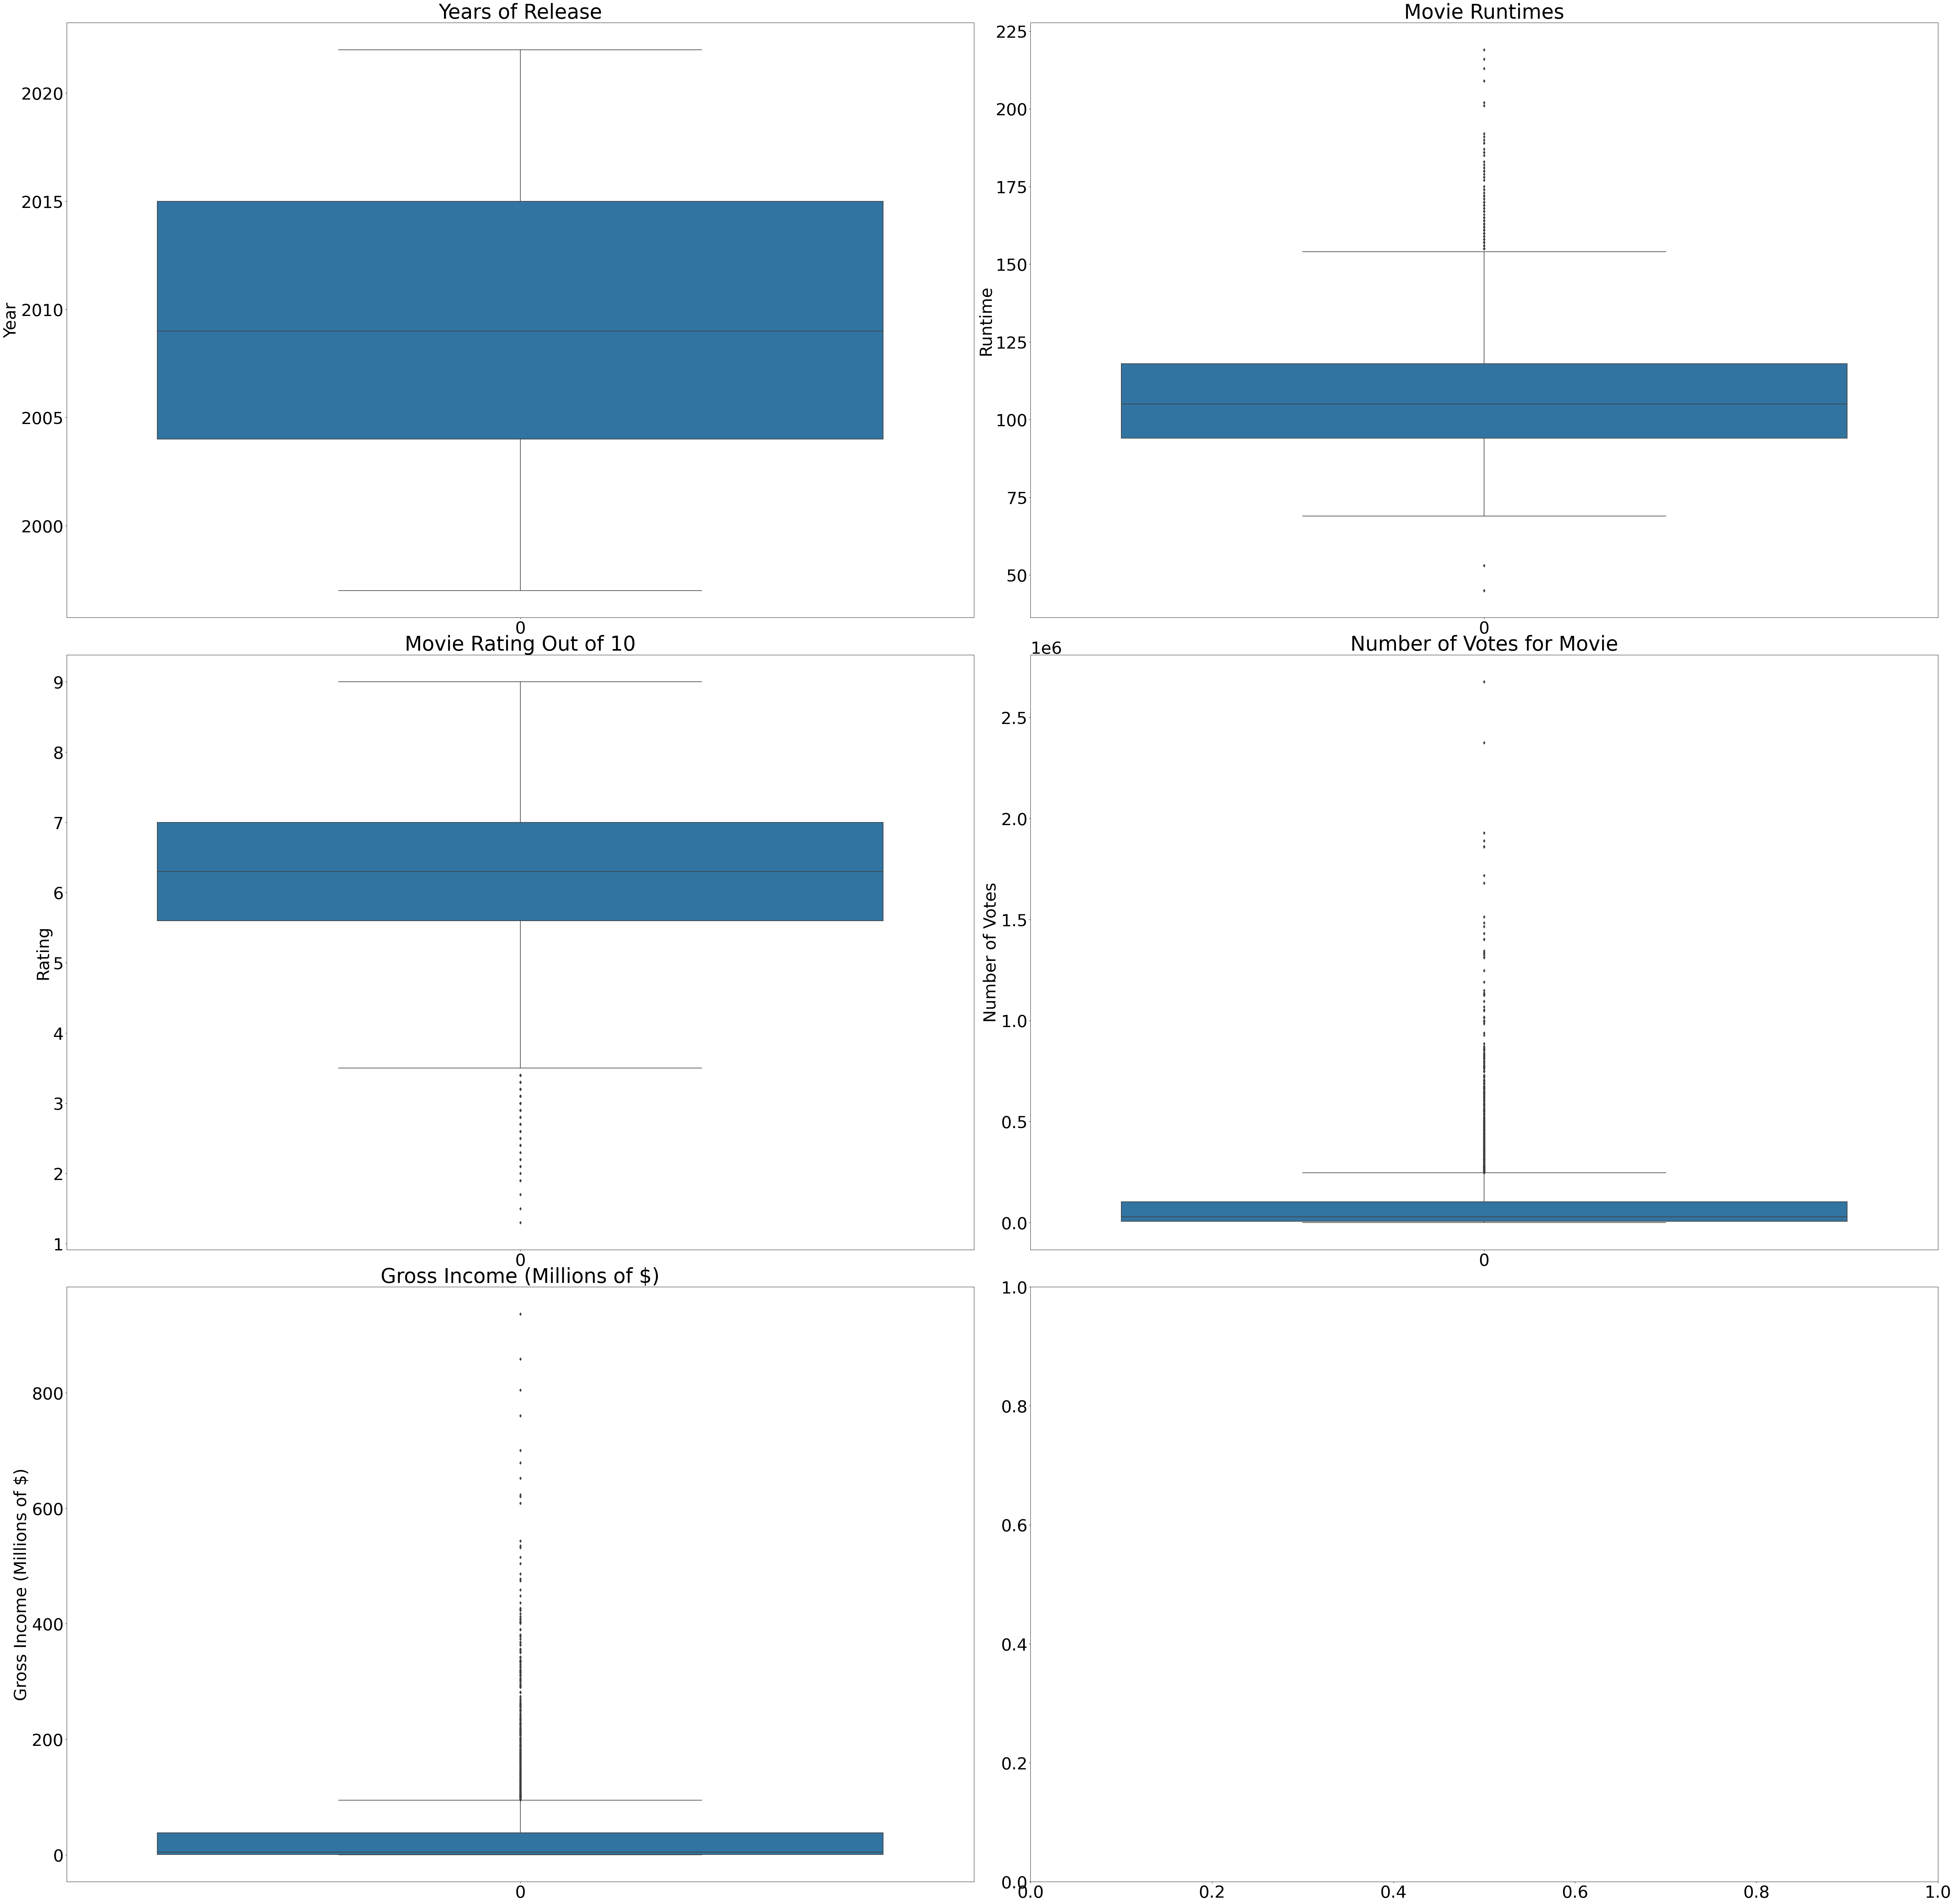

In [10]:
import seaborn as sns
plt.figure(figsize=(60,40))
plt.rc('font', size=40)          # controls default text sizes    # fontsize of the x and y labels
plt.rc('xtick', labelsize=40)    # fontsize of the tick labels
plt.rc('ytick', labelsize=40) 
fig, (ax1, ax2, ax3) = plt.subplots(3, 2, gridspec_kw={'wspace':1/16, 'hspace':1/16}, figsize=(80, 80))

sns.boxplot(df['year'],ax=ax1[0])
ax1[0].set_title('Years of Release')
ax1[0].set_ylabel('Year')

sns.boxplot(df['runtime'],ax=ax1[1])
ax1[1].set_title('Movie Runtimes')
ax1[1].set_ylabel('Runtime')

sns.boxplot(df['rating'],ax=ax2[0])
ax2[0].set_title('Movie Rating Out of 10')
ax2[0].set_ylabel('Rating')

sns.boxplot(df['votes'],ax=ax2[1])
ax2[1].set_title('Number of Votes for Movie')
ax2[1].set_ylabel('Number of Votes')

sns.boxplot(df['gross(in $)'],ax=ax3[0])
ax3[0].set_title('Gross Income (Millions of $)')
ax3[0].set_ylabel('Gross Income (Millions of $)')

C:\Users\Carly Freedman\AppData\Local\Temp\ipykernel_8652\8720258.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<AxesSubplot: >

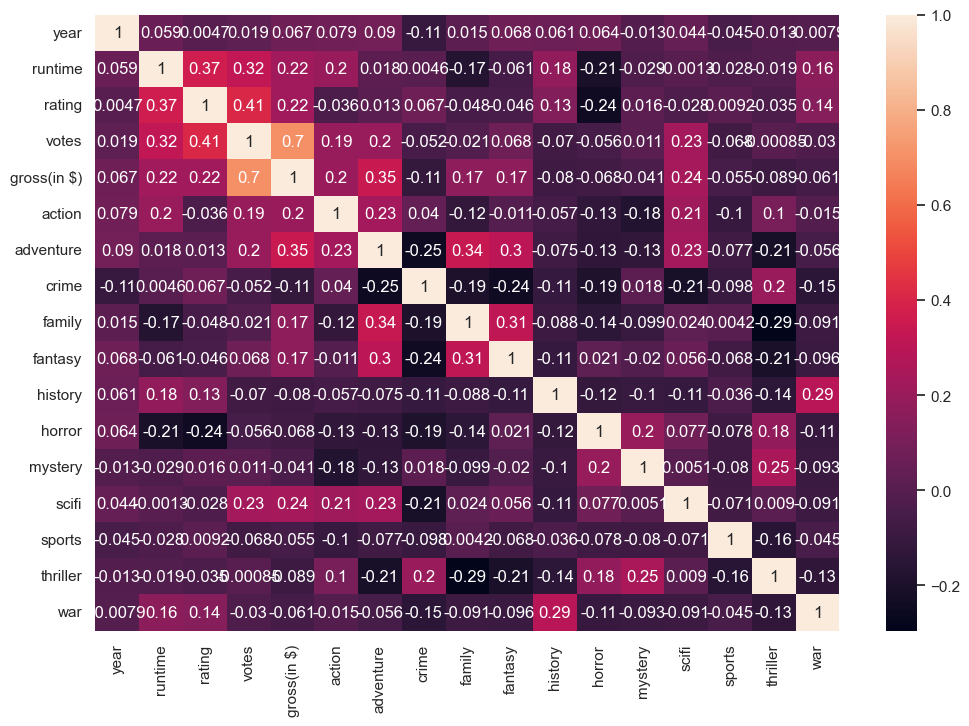

In [11]:
import seaborn as sns
# Correlation Matrix, dropping Film-Noir since none are in our dataframe anymore from the last 25 years
sns.set(rc={'figure.figsize':(12, 8)})
sns.heatmap(df.corr(), annot=True)

# Proposed Solution

We are going to use a few algorithms to approach the solution to this problem, but they are subsets of linear and nonlinear regression. This can be achieved through the use of sklearn's linear_model.LinearRegression. In addition to this, we will utilize a decision tree and support vector regressor as preliminary models, also in sklearn. Our problem is clearly a regression as we aim to predict gross earnings from our features, instead of a classification problem in which something like logistic regression would be preferred. To test our solution, we will run cross-validation on our dataset to generate an estimate of our model's performance. A baseline solution is a linear regression model on a simple 80-20 train-test split of our data, along with a correlation matrix that may illuminate underlying linear relationships in the data.

Because our problem has a very simple goal to achieve, we want to introduce nuance via complex approaches to analyzing the algorithms we use. We’ll use a few different standard model approaches including Gradient Boosting and Random Forest, as well as more complex approaches such as XGBoost and compare the results across each model. Again, because of the simplicity of our problem, we can also extend our analysis to using some hyperparameter optimization techniques and hope to establish good baselines, especially since we are most likely to use repeated k-fold cross-validation given that our dataset has over 18000 examples.

# Evaluation Metrics

To predict the box office gross income of movies based on their year, certificate, runtime, genre, rating and total number of votes, we will be potentially using the following metrics. 

Mean Absolute Error to measure the average absolute difference between the predicted box office gross and the actual box office gross across all the movies.

MAE = (1 / n) * sum(abs(y_true - y_pred))

Mean Squared Error and Root Mean Squared Error to measure the square root of the average squared difference between the predicted box office gross and the actual box office gross.

MSE = (1 / n) * sum((y_true - y_pred)^2)

RMSE = sqrt((1 / n) * sum((y_true - y_pred)^2))

And R2 Score to measure how well the regression model fits the actual data

R2 Score = 1 - (sum((y_true - y_pred)^2) / sum((y_true - mean(y_true))^2))

y_true = actual box office gross

y_pred = predicted box office gross

# Results


### Model Selection based on EDA

From our EDA, we observe the relative distributions of our features. Year is relatively uniform, our certificates are largely R-rated movies on IMDb, runtime is normal and centered around ~2 hour movies, action and thriller movies are the largest genres, ratings are normal and centered around 5-6, votes are skewed positively, and gross earnings are skewed positively. The related skew with votes and gross earnings gives us reason to believe that these features are somewhat correlated, and it is likely that a general linear relationship with slight nonlinearities exists within our data. As such, we believe that models that work strongly on linear data would be a reasonable approach to our regression task.

### Feature Selection / Data Transformation

We predicted beforehand that given the wide span of data we had (year-wise), that an appropriate choice of trimming our data was to locate a uniform section of our data that we could perform regression on. We believed that too many complexities existed if we go back too far in time; for example, the greater proportion of film-noir that fell extremely out of popularity as the movie industry grew, the issue of inflation affecting earnings, and the small distribution of theaters and underdevelopment of movie culture. As such, we chose to isolate a subset of the data that seemed to have a steady (uniform) distribution of movies. In order to do that, we put the movies into bins based on year and identified that subset to be between 1997 to 2022. Additionally, in order to use the genre of a movie as a potential feature, we chose to one-hot encode it as the genre doesn’t seem to be ordinal in nature (i.e. action movies are not greater or lesser than history movies).

### Baseline Performance Analysis

Our initial assumptions of the data are somewhat confirmed by this correlation heatmap. Noting that votes and gross earnings are somewhat correlated at 0.7, we attempt an initial linear regression analysis to observe its performance on our data. Unfortunately, this performed significantly worse than the dataframe’s internal correlation function, showing an existent but weaker correlation. Nevertheless, this did not deter our future efforts to identify the relationship between our features and gross earnings as somewhat linear. Thus we continue to use MSE and R2 as primary predictors as MSE punishes poor predictions and R2 is the correlation we hope to identify.


### Model Comparisons

In our project we run five different models and compute the error metrics MSE and RMSE as well as review their correlation with the R-squared coefficient. We find that the linear regression performs the worst as it has the lowest correlation and the highest MSE. The decision tree outperformed the linear regression model with a higher correlation and lower MSE. The models with the best performance are the XGBoost, Random Forest, and the Support Vector Regressor which all had an R-squared value above 0.7 and smaller MSEs, however, of these three, the Random Forest has the smallest MSE. We also tried running a Grid Search algorithm the k-fold cross validation, however this model didn’t perform as well as the Random Forest meaning it had a smaller correlation score and higher MSE.



## Using 'Year' as Numerical

In [12]:
features = list(df.columns)
X_train, X_test, y_train, y_test = train_test_split(df[[f for f in features if f not in ['gross(in $)']]]
                                                    , df['gross(in $)'], test_size=0.2, random_state=42)

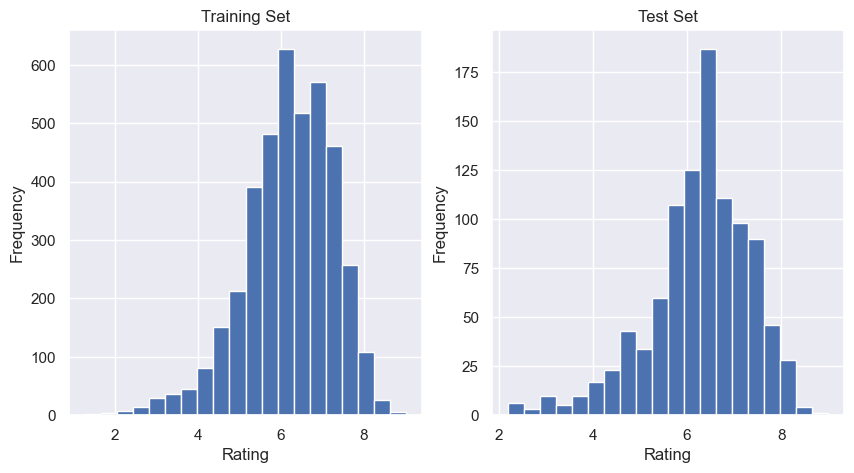

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(X_train['rating'], bins=20)
ax[0].set_title('Training Set')
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Frequency')
ax[1].hist(X_test['rating'], bins=20)
ax[1].set_title('Test Set')
ax[1].set_xlabel('Rating')
ax[1].set_ylabel('Frequency')
plt.show()

In [14]:
num_scaler = StandardScaler()
ohe_encoder = OneHotEncoder()

In [15]:
X_train_num = X_train[[f for f in features if f not in ['gross(in $)', 'certificate']]]
X_train_cat = X_train[['certificate']]

X_train_num_scaled = num_scaler.fit_transform(X_train_num)
X_train_cat_encoded = ohe_encoder.fit_transform(X_train_cat)

In [16]:
X_train_preprocessed = pd.concat([
    pd.DataFrame(X_train_num_scaled, columns=[f for f in features if f not in ['gross(in $)', 'certificate']]),
    pd.DataFrame(X_train_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate']))
], axis=1)

In [17]:
X_test_num = X_test[[f for f in features if f not in ['gross(in $)', 'certificate']]]
X_test_cat = X_test[['certificate']]

X_test_num_scaled = num_scaler.transform(X_test_num)
X_test_cat_encoded = ohe_encoder.transform(X_test_cat)

In [18]:
X_test_preprocessed = pd.concat([
    pd.DataFrame(X_test_num_scaled, columns=[f for f in features if f not in ['gross(in $)', 'certificate']]),
    pd.DataFrame(X_test_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate']))
], axis=1)

## Linear Regression

In [19]:
model = LinearRegression()
model.fit(X_train_preprocessed, y_train)
y_pred = model.predict(pd.concat([pd.DataFrame(X_test_num_scaled, columns=[f for f in features if f not in ['gross(in $)', 'certificate']]), 
                                  pd.DataFrame(X_test_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate']))], axis=1))

print('R2 score:', r2_score(y_test, y_pred))
print('Mean squared error:', mean_squared_error(y_test, y_pred))
print('Mean absolute error:', mean_absolute_error(y_test, y_pred))



R2 score: 0.5490725989448865
Mean squared error: 2550.6725760605877
Mean absolute error: 25.96020192470295


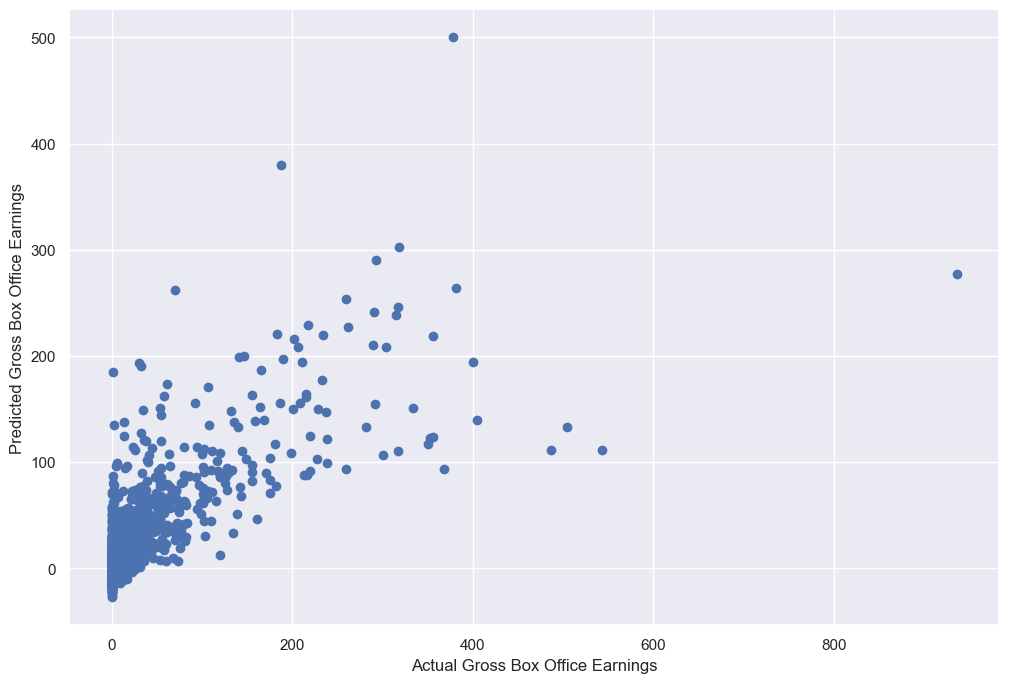

In [20]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Gross Box Office Earnings")
plt.ylabel("Predicted Gross Box Office Earnings")
plt.show()

## Decision Tree

In [21]:
model = DecisionTreeRegressor()
model.fit(X_train_preprocessed, y_train)
y_pred = model.predict(X_test_preprocessed)

print('R2 score:', r2_score(y_test, y_pred))
print('Mean squared error:', mean_squared_error(y_test, y_pred))
print('Mean absolute error:', mean_absolute_error(y_test, y_pred))

R2 score: 0.5601352084320648
Mean squared error: 2488.0968830053666
Mean absolute error: 21.33567003670635


## Using Year as Categorical (5-year increment)

In [22]:
df['year_category'] = (((df['year'] - 1995) // 5) * 5 + 1995).astype(str) + '-' + (((df['year'] - 1995) // 5) * 5 + 1999).astype(str)
df.head()

,year,certificate,runtime,rating,votes,gross(in $),action,adventure,crime,family,fantasy,history,horror,mystery,scifi,sports,thriller,war,year_category
0,2018,PG-13,134.0,7.3,785813.0,700.059566,1,1,0,0,0,0,0,0,1,0,0,0,2015-2019
1,2009,PG-13,162.0,7.9,1322694.0,760.507625,1,1,0,0,1,0,0,0,1,0,0,0,2005-2009
2,2012,PG-13,142.0,7.2,927499.0,408.010692,1,1,0,0,0,0,0,0,1,0,1,0,2010-2014
3,2021,PG-13,155.0,8.0,649342.0,108.327830,1,1,0,0,0,0,0,0,1,0,0,0,2020-2024
4,2001,PG-13,178.0,8.8,1889727.0,315.544750,1,1,0,0,1,0,0,0,0,0,0,0,2000-2004


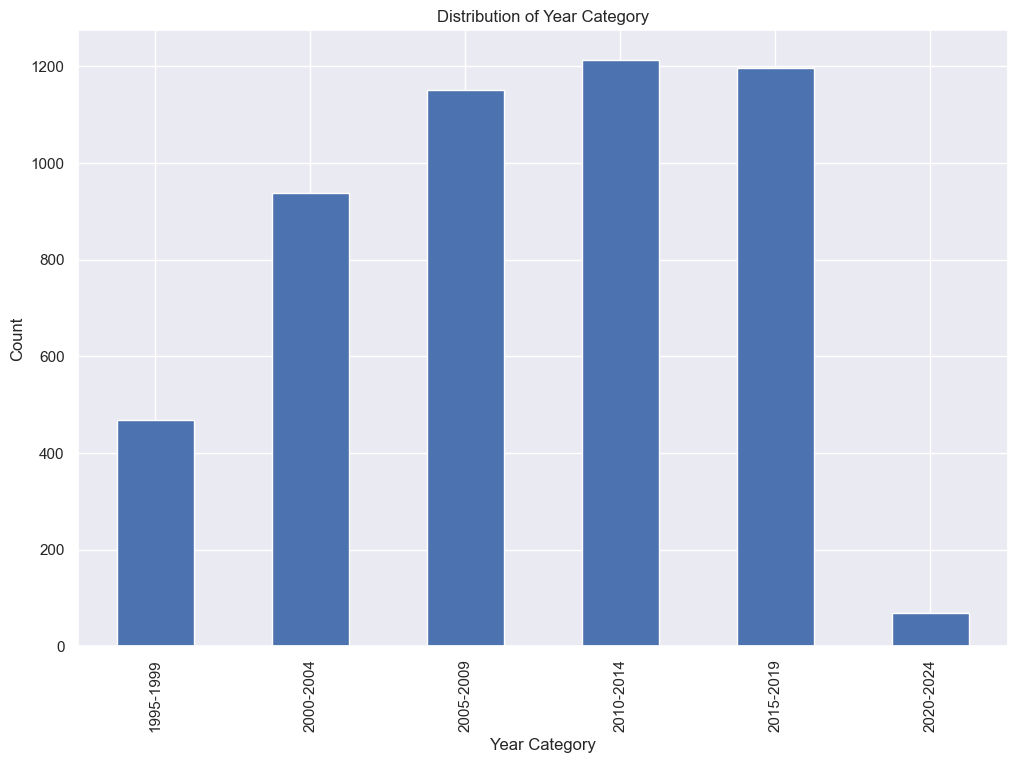

In [23]:
year_counts = df['year_category'].value_counts().sort_index()
year_counts.plot.bar()
plt.title('Distribution of Year Category')
plt.xlabel('Year Category')
plt.ylabel('Count')
plt.show()

In [24]:
features.append('year_category')
X_train, X_test, y_train, y_test = train_test_split(df[[f for f in features if f not in ['year', 'gross(in $)']]]
                                                    , df['gross(in $)'], test_size=0.2, random_state=42)

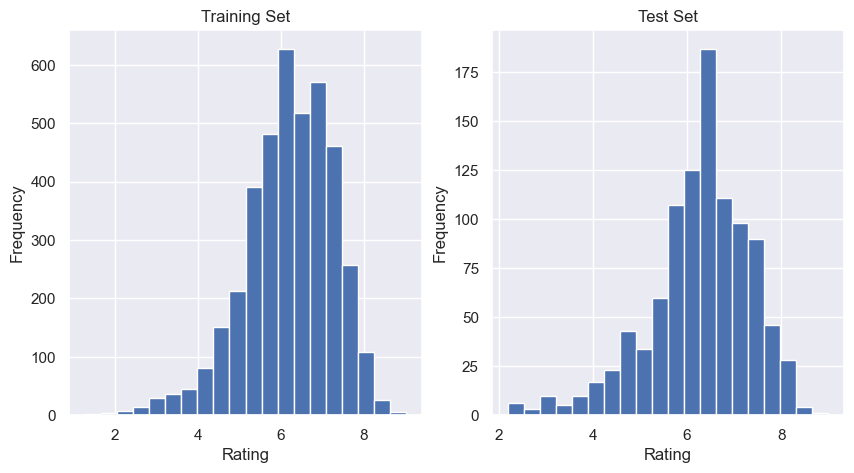

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(X_train['rating'], bins=20)
ax[0].set_title('Training Set')
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Frequency')
ax[1].hist(X_test['rating'], bins=20)
ax[1].set_title('Test Set')
ax[1].set_xlabel('Rating')
ax[1].set_ylabel('Frequency')
plt.show()

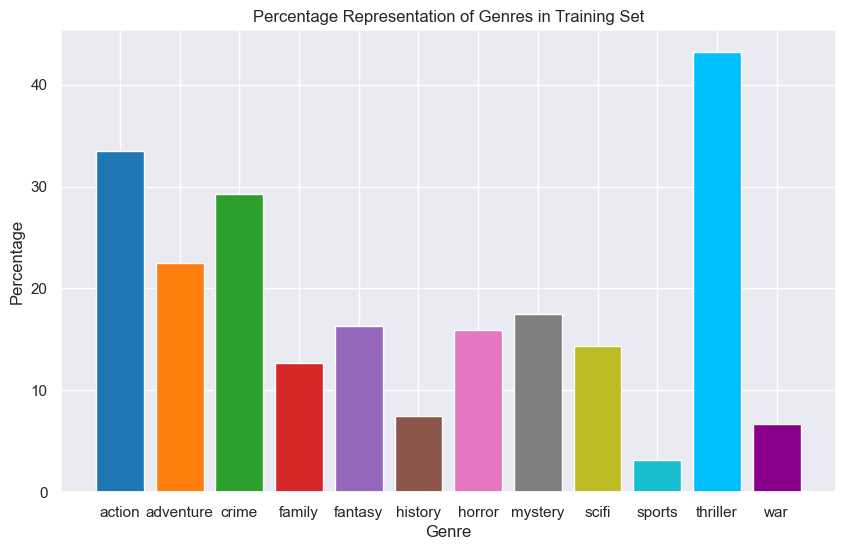

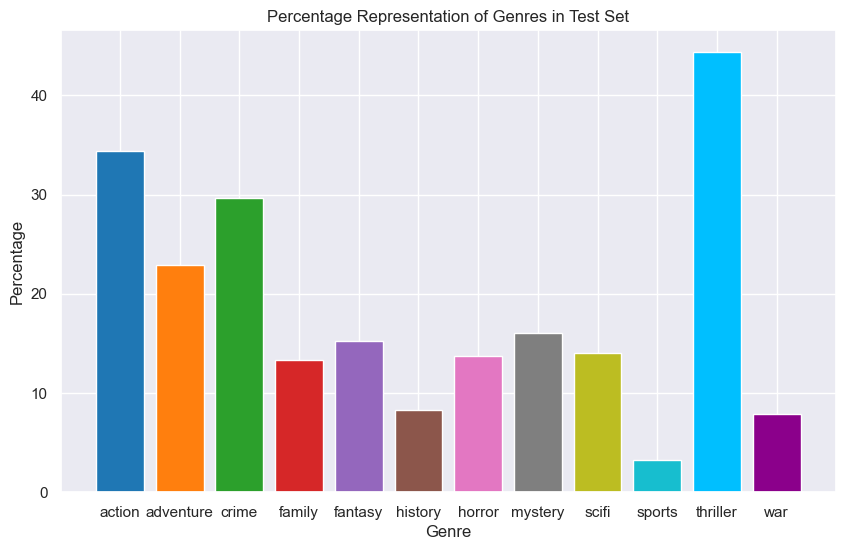

In [26]:
# Distribution of Genres
# Extract the genre columns from the train and test sets
genre_cols = ['action', 'adventure', 'crime', 'family', 'fantasy', 'history', 'horror', 'mystery', 'scifi', 'sports', 'thriller', 'war']
X_train_genre = X_train[genre_cols]
X_test_genre = X_test[genre_cols]

# Define colors for each genre
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#00bfff', '#8b008b', '#ff1493']

# Calculate percentage representation of each genre in the training set
train_genre_counts = X_train_genre.sum(axis=0)
train_genre_percents = train_genre_counts / len(X_train_genre) * 100

# Plot barplot for training set
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(train_genre_percents.index, train_genre_percents, color=colors)
plt.title('Percentage Representation of Genres in Training Set')
plt.xlabel('Genre')
plt.ylabel('Percentage')
plt.show()

# Calculate percentage representation of each genre in the test set
test_genre_counts = X_test_genre.sum(axis=0)
test_genre_percents = test_genre_counts / len(X_test_genre) * 100

# Plot barplot for test set
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(test_genre_percents.index, test_genre_percents, color=colors)
plt.title('Percentage Representation of Genres in Test Set')
plt.xlabel('Genre')
plt.ylabel('Percentage')
plt.show()


In [27]:
X_train_num = X_train[[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]]
X_train_cat = X_train[['certificate', 'year_category']]

X_train_num_scaled = num_scaler.fit_transform(X_train_num)
X_train_cat_encoded = ohe_encoder.fit_transform(X_train_cat)

In [28]:
X_train_preprocessed = pd.concat([
    pd.DataFrame(X_train_num_scaled, columns=[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]),
    pd.DataFrame(X_train_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate','year_category']))
], axis=1)

In [29]:
X_test_num = X_test[[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]]
X_test_cat = X_test[['certificate', 'year_category',]]

X_test_num_scaled = num_scaler.transform(X_test_num)
X_test_cat_encoded = ohe_encoder.transform(X_test_cat)

In [30]:
X_test_preprocessed = pd.concat([
    pd.DataFrame(X_test_num_scaled, columns=[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]),
    pd.DataFrame(X_test_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate', 'year_category']))
], axis=1)

## Linear Regression

In [31]:
model = LinearRegression()
model.fit(X_train_preprocessed, y_train)
y_pred = model.predict(pd.concat([pd.DataFrame(X_test_num_scaled, columns=[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]), 
                                  pd.DataFrame(X_test_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate', 'year_category']))], axis=1))

print('R2 score:', r2_score(y_test, y_pred))
print('Mean squared error:', mean_squared_error(y_test, y_pred))
print('Mean absolute error:', mean_absolute_error(y_test, y_pred))

R2 score: 0.5489654337175492
Mean squared error: 2551.278756580638
Mean absolute error: 26.07476729217989


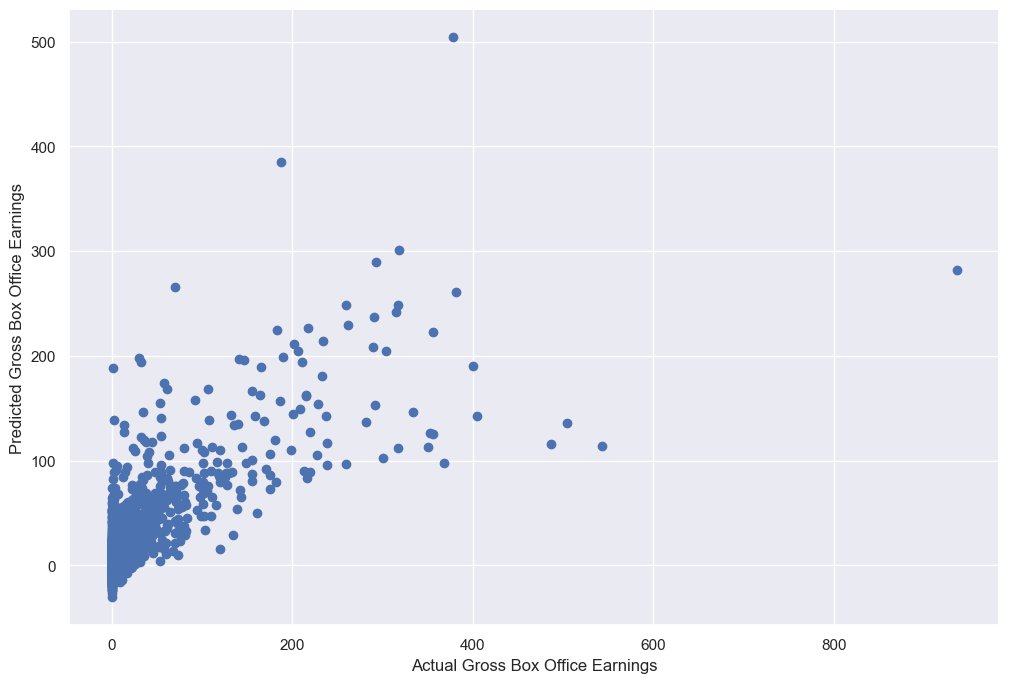

In [32]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Gross Box Office Earnings")
plt.ylabel("Predicted Gross Box Office Earnings")
plt.show()

## Decision Tree

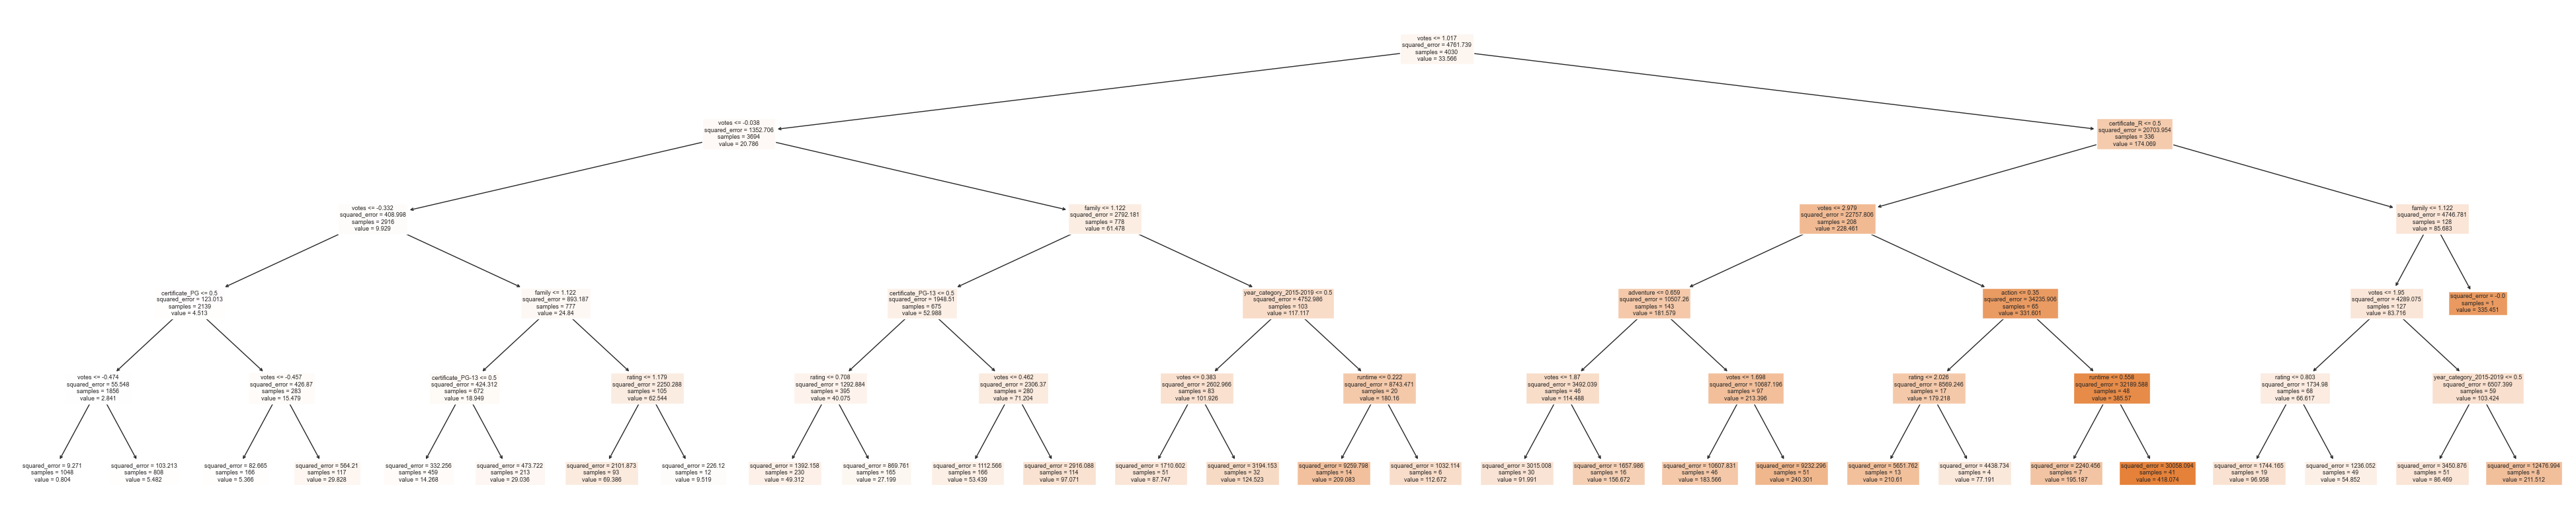

R2 score: 0.6089533052788741
Mean squared error: 2211.9571306832245
Mean absolute error: 21.07488415383571


In [33]:
model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train_preprocessed, y_train)
y_pred= model.predict(pd.concat([pd.DataFrame(X_test_num_scaled, columns=[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]),
                                  pd.DataFrame(X_test_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate', 'year_category']))], axis=1))

feature_names = X_train_preprocessed.columns
plt.figure(figsize=(50, 10))
plot_tree(model, filled=True, feature_names=feature_names)
plt.show()

print('R2 score:', r2_score(y_test, y_pred))
print('Mean squared error:', mean_squared_error(y_test, y_pred))
print('Mean absolute error:', mean_absolute_error(y_test, y_pred))

## SVR

In [34]:
model = SVR(kernel='rbf', C=100, gamma='auto')
model.fit(X_train_preprocessed, y_train)
y_pred = model.predict(pd.concat([pd.DataFrame(X_test_num_scaled, columns=[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]), 
                                  pd.DataFrame(X_test_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate', 'year_category']))], axis=1))

print('R2 score:', r2_score(y_test, y_pred))
print('Mean squared error:', mean_squared_error(y_test, y_pred))
print('Mean absolute error:', mean_absolute_error(y_test, y_pred))

R2 score: 0.7177216785143299
Mean squared error: 1596.7084097023248
Mean absolute error: 17.289602303412114


## Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_preprocessed, y_train)

y_pred = rf.predict(pd.concat([pd.DataFrame(X_test_num_scaled, columns=[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]), 
                                  pd.DataFrame(X_test_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate', 'year_category']))], axis=1))
mse = mean_squared_error(y_test, y_pred)
print('R2 score:', r2_score(y_test, y_pred))
print('Mean squared error:', mse)
print('Mean absolute error:', mean_absolute_error(y_test, y_pred))

R2 score: 0.7402162209709615
Mean squared error: 1469.4679438958397
Mean absolute error: 16.84431115661756


## XGBoost

In [36]:
model = xgb.XGBRegressor()
model.fit(X_train_preprocessed, y_train)

y_pred = model.predict(X_test_preprocessed)

mse = mean_squared_error(y_test, y_pred)
print('R2 score:', r2_score(y_test, y_pred))
print('Mean squared error:', mse)
print('Mean absolute error:', mean_absolute_error(y_test, y_pred))

R2 score: 0.7448632455571313
Mean squared error: 1443.1820314751521
Mean absolute error: 17.355981958143502


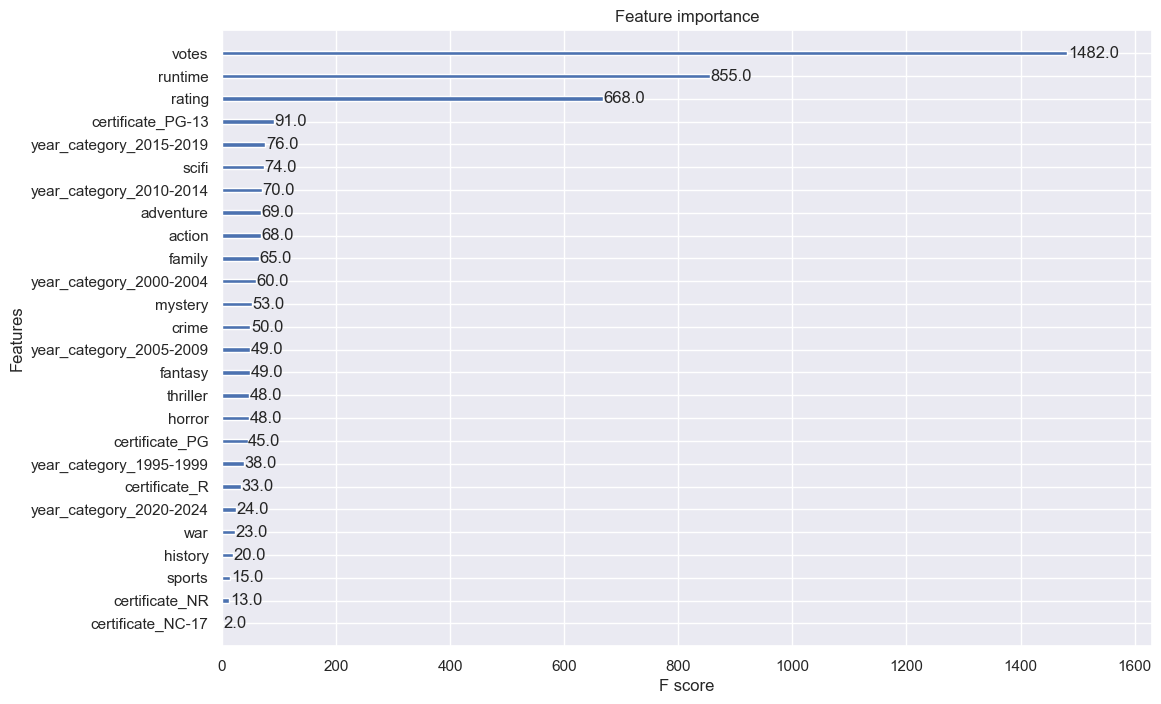

In [37]:
xgb.plot_importance(model)
plt.show()

## Hyperparameter Optimization: Grid Search on Gradient Boosting

In [38]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV

gbr = GradientBoostingRegressor()
grid = dict()
grid['n_estimators'] = [10, 50, 100, 1000]
grid['learning_rate'] = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3, 5, 7]

rskf = RepeatedKFold(n_repeats=3, n_splits=10, random_state=420210)
grid_search = GridSearchCV(estimator=gbr, param_grid=grid, cv=rskf)
# search over our floating values
grid_result = grid_search.fit(X=df[[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]], y=df['gross(in $)'])

KeyboardInterrupt: 

In [ ]:
print('OPTIMAL: %f with params: %s' % (grid_result.best_score_, grid_result.best_params_))

test_means = grid_result.cv_results_['mean_test_score']
test_stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for test_mean, test_std, param in zip(test_means, test_stds, params):
    print("%f (%f) with params: %r" % (test_mean, test_std, param))

# Discussion

### Interpreting the result

After comparing multiple models and hypertuning some of the hyperparameters, we came to the conclusion that the Random Forest did the best job at modeling our data. The Random Forest seemed to model our data well since it can handle nonlinear data well, in our case, parameters like number of votes on IMDB and movie genre. It also is good at handling outliers in the data which is important in our case as our data contains a lot of points that fall outside of the 1.5 times the IQR range. We believe it’s this combination of characteristics that led our Random Forest model to have the greatest r-squared correlation and smallest mean-squared error. However, a second model that performed almost just as well was our XGBoost model, which does a great job at estimating the feature importance of the features in our dataset. For example, in our data set, the number of votes on IMDB was way more important than the other features in our data, followed by movie runtime and movie rating. The rest of the features seemed to have much less impact. This shows us why a model such as XGBoost performs significantly better than our linear regression model or decision tree model since these models weigh the input features equally. While the predictions of some of our better models are relatively accurate, they still may be too inaccurate to really be usable. The stronger models have a MAE error of around 17 units, which in our case would be 17 million dollars. In the context of our problem, probably a higher level of accuracy is needed.

### Limitations

When we began the problem, the dataset appeared to be full of useful information. We started off with nearly 300,000 data points. After parsing through and eliminating null or unusable data, we were left with 80,000 observations. The data was formatted into 13 CSV files: one for each genre of movie. This resulted in the same movies being printed out twice. Also, because the genre column of the data contained many genres including ones not provided as CSV’s, it was very tricky to tell what a movie’s true genre was. We decided to label each movie as the genre or genres whose csv files they were listed under. 
After removing the duplicates we were left with around 10,000 data points. This was sufficient to get a model to run, but as evidenced by our accuracies it wasn’t the strongest base for training a model. If we had more usable data then we might have been able to improve the accuracy of the model by a considerable amount. 

### Ethics & Privacy

The IMDB dataset is downloaded from the Kaggle website with no personal or sensitive information included from human participants. All the variables in the dataset are available to the public on IMDB website in which we can eliminate the concern for data privacy and misuse of the data. The movie ratings and box office gross are largely influenced by the viewers and fans of particular franchises and movie stars which may be biased, however, since we are using a large dataset with a huge number of ratings, the bias could be neglected or will be evaluated and addressed if the concerns were to arise. Our final product will be available to students of current COGS 118A class, future prospective students and potentially to the public and we will carefully monitor and identify the unintended use of our project.

### Conclusion

We ran six different models to try to predict the gross income of movies based on their year of release, certificate, rating, runtime, genre, and number of votes. Overall, none of the models we tried ultimately yielded any significant results. This might be an indication that we lacked a sufficient amount of data. While the dataset started out extremely large, as aforementioned we had to cut out a significant portion of it in order for it to be usable. Another possible source of error is that the features we selected and were provided in the data just might not have been good indicators of the gross income of a movie. For example, the dataset provided the main star/actor in each movie, but we cut this out as it was categorical and illogical to one-hot-encode and therefore would not have worked with the models we chose to run. However maybe this, or more information that was omitted from the dataset entirely would have been better indicators. Perhaps we needed more information that was never in the dataset. The model that yielded the best results was the random forest. 


# Footnotes
<a name="doshinote"></a>1.[^](#doshi): Doshi, Lyric, et al. Predicting Movie Prices through Dynamic Social Network Analysis - Core. https://core.ac.uk/download/pdf/82778929.pdf. <br> 

<a name="dhirnote"></a>2.[^](#dhir): Dhir R, Raj A (2018) Movie success prediction using machine learning algorithms and their comparison. In: 2018 First International Conference on Secure Cyber Computing and Communication (ICSCCC), IEEE, pp 385–390. <br>

<a name='abidinote'></a>3.[^](#abidi): Abidi, S.M.R., Xu, Y., Ni, J. et al. Popularity prediction of movies: from statistical modeling to machine learning techniques. Multimed Tools Appl 79, 35583–35617 (2020). https://doi.org/10.1007/s11042-019-08546-5. <br>